In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the CSV and Excel files
scada_df = pd.read_csv("G:\\turbine_ad\\raw\\T06_2017.csv")
logs_df = pd.read_csv("G:\\turbine_ad\\raw\\T06_logs_2017.csv")
failures_df = pd.read_csv("G:\\turbine_ad\\raw\\T06_failures_2017.csv")

# Display the first few rows of each dataset to understand their structure
turbine_data_head = scada_df.head()
turbine_logs_head = logs_df.head()
failure_data_sheets = {sheet: data.head() for sheet, data in failures_df.items()}

turbine_data_head, turbine_logs_head, failure_data_sheets


(  Turbine_ID                  Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
 0        T06  2017-01-01 00:00:00+00:00       1464.0       1236.3   
 1        T06  2017-01-01 00:10:00+00:00       1462.8       1238.3   
 2        T06  2017-01-01 00:20:00+00:00       1393.5       1239.2   
 3        T06  2017-01-01 00:30:00+00:00       1415.6       1243.5   
 4        T06  2017-01-01 00:40:00+00:00       1326.9       1232.2   
 
    Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
 0       1318.6         52.4               39.0                 54.0   
 1       1310.6         44.1               39.0                 54.0   
 2       1288.3         30.0               39.0                 54.0   
 3       1273.5         29.6               39.0                 54.0   
 4       1259.9         12.3               39.0                 54.0   
 
    Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Grd_Prod_PsbleInd_Avg  \
 0                 56.0                 56.0  ...                -10

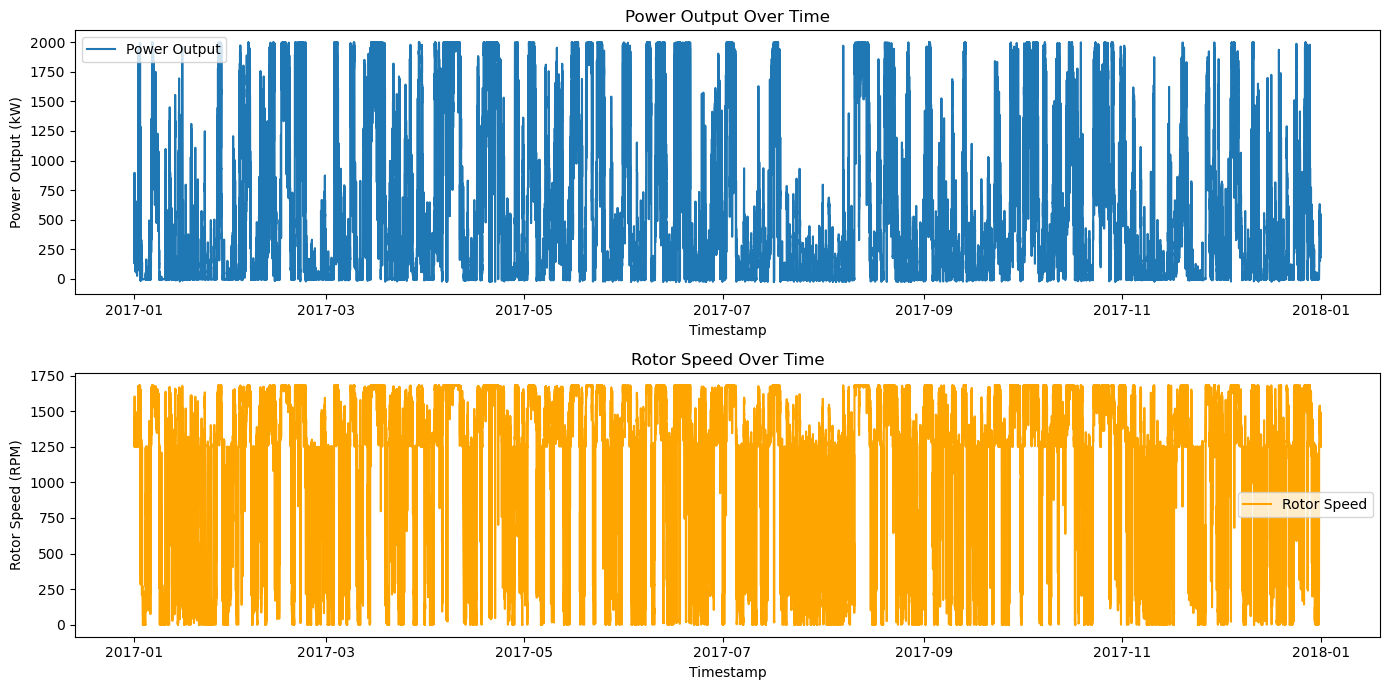

In [4]:
# Convert the timestamp columns to datetime
scada_df["Timestamp"] = pd.to_datetime(scada_df["Timestamp"])
logs_df["Time_Detected"] = pd.to_datetime(logs_df["Time_Detected"])
failures_df["Timestamp"] = pd.to_datetime(failures_df["Timestamp"])

# Extract relevant columns from SCADA data
scada_relevant = scada_df[["Timestamp", "Gen_RPM_Avg", "Grd_Prod_Pwr_Avg"]]

# Assuming 'Op_State' is equivalent to operational status, we need to find this column
# For now, let's define shutdown periods based on Gen_RPM_Avg and Grd_Prod_Pwr_Avg being zero or very low
shutdowns = scada_relevant[
    (scada_relevant["Gen_RPM_Avg"] == 0) | (scada_relevant["Grd_Prod_Pwr_Avg"] == 0)
]

# Merge SCADA data with logs to correlate with alarm codes
merged_data = pd.merge(
    shutdowns, logs_df, left_on="Timestamp", right_on="Time_Detected", how="left"
)

plt.figure(figsize=(14, 7))

# Plot Power Output
plt.subplot(2, 1, 1)
plt.plot(scada_df["Timestamp"], scada_df["Grd_Prod_Pwr_Avg"], label="Power Output")
plt.xlabel("Timestamp")
plt.ylabel("Power Output (kW)")
plt.title("Power Output Over Time")
plt.legend()

# Plot Rotor Speed
plt.subplot(2, 1, 2)
plt.plot(
    scada_df["Timestamp"], scada_df["Gen_RPM_Avg"], label="Rotor Speed", color="orange"
)
plt.xlabel("Timestamp")
plt.ylabel("Rotor Speed (RPM)")
plt.title("Rotor Speed Over Time")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the duration of each shutdown event
shutdown_durations = shutdowns["Timestamp"].diff().fillna(pd.Timedelta(seconds=0))
shutdown_durations = shutdown_durations[shutdown_durations != pd.Timedelta(seconds=0)]


In [7]:
import numpy as np

# Define thresholds for sudden drops
drop_threshold_rpm = 500  # RPM drop threshold
drop_threshold_power = 10  # Power drop threshold (kW)
low_threshold_rpm = 10  # RPM low threshold
low_threshold_power = 10  # Power low threshold
consecutive_points = 5  # Number of consecutive points to check

# Compute differences
scada_df["RPM_Diff"] = scada_df["Gen_RPM_Avg"].diff().abs()
scada_df["Power_Diff"] = scada_df["Grd_Prod_Pwr_Avg"].diff().abs()

# Identify sudden drops
sudden_drops = scada_df[
    (
        (scada_df["RPM_Diff"] > drop_threshold_rpm)
        | (scada_df["Power_Diff"] > drop_threshold_power)
    )
]


In [8]:
# Initialize a list to store flagged events
flagged_events = []

# Check subsequent values
for idx in sudden_drops.index:
    if idx + consecutive_points < len(scada_df):
        subsequent_rpm = scada_df.loc[idx + 1 : idx + consecutive_points, "Gen_RPM_Avg"]
        subsequent_power = scada_df.loc[
            idx + 1 : idx + consecutive_points, "Grd_Prod_Pwr_Avg"
        ]

        if (subsequent_rpm < low_threshold_rpm).all() or (
            subsequent_power < low_threshold_power
        ).all():
            flagged_events.append(scada_df.loc[idx])


In [12]:
# Create a DataFrame for flagged events
flagged_events_df = pd.DataFrame(flagged_events)
flagged_events_df.head()


,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg,RPM_Diff,Power_Diff
358,T06,2017-01-03 11:40:00+00:00,1260.3,247.7,644.9,466.3,40.0,52.0,54.0,54.0,...,-100.2,15.5,3.9,100.2,0.0,15.5,36.0,95.2,603.8,29.2
523,T06,2017-01-04 15:10:00+00:00,1275.6,1233.2,1249.2,6.7,37.0,37.0,37.0,38.0,...,-950.0,190.9,250.6,950.0,0.0,190.9,41.0,327.6,484.2,14.8
524,T06,2017-01-04 15:20:00+00:00,1384.9,30.6,896.6,449.2,38.0,39.0,39.0,40.0,...,-942.2,115.3,35.4,942.2,0.0,115.3,41.0,327.6,352.6,49.7
525,T06,2017-01-04 15:30:00+00:00,1012.8,0.0,194.8,155.0,38.0,39.0,40.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,331.1,701.8,6.9
526,T06,2017-01-04 15:40:00+00:00,1357.5,210.0,731.0,496.5,37.0,40.0,40.0,40.0,...,-600.1,81.7,29.6,600.1,0.0,81.7,41.0,339.2,536.2,7.0


In [14]:
# Remove rows with null values in the merge key columns
logs_df_clean = logs_df.dropna(subset=["Time_Detected"])
failures_df_clean = failures_df.dropna(subset=["Timestamp"])
flagged_events_df_clean = flagged_events_df.dropna(subset=["Timestamp"])

# Merge flagged events with logs and failures
merged_logs = pd.merge_asof(
    flagged_events_df_clean.sort_values("Timestamp"),
    logs_df_clean.sort_values("Time_Detected"),
    left_on="Timestamp",
    right_on="Time_Detected",
    direction="nearest",
    tolerance=pd.Timedelta("1h"),
)
merged_failures = pd.merge_asof(
    flagged_events_df_clean.sort_values("Timestamp"),
    failures_df_clean.sort_values("Timestamp"),
    on="Timestamp",
    direction="nearest",
    tolerance=pd.Timedelta("1h"),
)
# Display the results
merged_logs.head()


,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg,RPM_Diff,Power_Diff,Time_Detected,Time_Reset,Turbine_Identifier,Remark,Unit_Title_Destination
0,T06,2017-01-03 11:40:00+00:00,1260.3,247.7,644.9,466.3,40.0,52.0,54.0,54.0,...,15.5,36.0,95.2,603.8,29.2,2017-01-03 11:14:42+00:00,NaN,T06,Generator 1 in,NaN
1,T06,2017-01-04 15:10:00+00:00,1275.6,1233.2,1249.2,6.7,37.0,37.0,37.0,38.0,...,190.9,41.0,327.6,484.2,14.8,2017-01-04 15:14:09+00:00,NaN,T06,Generator 1 in,NaN
2,T06,2017-01-04 15:20:00+00:00,1384.9,30.6,896.6,449.2,38.0,39.0,39.0,40.0,...,115.3,41.0,327.6,352.6,49.7,2017-01-04 15:22:44+00:00,NaN,T06,Accumulator test done -> OK,NaN
3,T06,2017-01-04 15:30:00+00:00,1012.8,0.0,194.8,155.0,38.0,39.0,40.0,40.0,...,0.0,40.0,331.1,701.8,6.9,2017-01-04 15:30:22+00:00,NaN,T06,Generator 1 in,NaN
4,T06,2017-01-04 15:40:00+00:00,1357.5,210.0,731.0,496.5,37.0,40.0,40.0,40.0,...,81.7,41.0,339.2,536.2,7.0,2017-01-04 15:40:55+00:00,NaN,T06,Generator 1 in,NaN


In [16]:
merged_failures.to_csv("G:\\turbine_ad\\raw\\merged_failures.csv")



In [17]:
merged_logs.to_csv("G:\\turbine_ad\\raw\\merged_logs.csv")


In [22]:
# I want to check how many negative values are in the column Grd_Prod_Pwr_Avg and their indexes
negative_power = scada_df[scada_df["Grd_Prod_Pwr_Avg"] < 0]


In [23]:
# how many of these values have a consecuitive negative value in the next 10 rows
negative_power["next_10"] = negative_power["Grd_Prod_Pwr_Avg"].rolling(10).sum()
# remmove the rows that do not have a consecutive negative value in the next 10 rows
negative_power.dropna(subset=["next_10"], inplace=True)


C:\Users\Hamza\AppData\Local\Temp\ipykernel_37184\4106018051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_power["next_10"] = negative_power["Grd_Prod_Pwr_Avg"].rolling(10).sum()
C:\Users\Hamza\AppData\Local\Temp\ipykernel_37184\4106018051.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_power.dropna(subset=["next_10"], inplace=True)


In [25]:
negative_power.to_csv("G:\\turbine_ad\\raw\\negative_power.csv")
